Autoencoders encode the input to identify important latent feature representation. It then decodes the latent features to reconstruct output values identical to the input values.

![](https://lilianweng.github.io/posts/2018-08-12-vae/autoencoder-architecture.png)

![](https://miro.medium.com/v2/resize:fit:828/format:webp/1*E6o2V3B-Vep374feBNbyeA.png)

The encoder will compress the input data to its latent representation. The decoder will decompress the encoded latent representation to reconstruct the input data. The loss between the original input and the reconstructed input will be measured using the **SSIM (Structural Similarity Index Measure)** loss function. If the input belongs to images from the trained dataset then reconstruction loss will be smaller and if there is an anomaly then the reconstruction loss will be high.

SSIM is used to measure the similarity between two images. The SSIM value is between -1 and 1. SSIM value is larger if two images are similar.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load MVTec Transistor Dataset

In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"atalaypabuu","key":"1a6cc847a55e48a8f9166f9dc2b7ce9b"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d 'leezhixiong/mvtec-transistor-dataset'

 99% 381M/384M [00:13<00:00, 38.0MB/s]
100% 384M/384M [00:13<00:00, 30.0MB/s]


In [7]:
import zipfile

# Unzip the downloaded file
def unzip_data(zip_file_name):
  zip_ref = zipfile.ZipFile(zip_file_name, "r")
  zip_ref.extractall()
  zip_ref.close()

In [8]:
unzip_data('/content/mvtec-transistor-dataset.zip')

In [9]:
DATASET_PATH = '/content/transistor'
DATASET_TRAINING_PATH = '/content/transistor/train/good'
DATASET_TEST_PATH = '/content/transistor/test'
DATASET_TEST_GOOD_PATH = '/content/transistor/test/good'
MODEL_CHECKPOINT_PATH = '/content/base_model_checkpoint/cp.ckpt'

In [10]:
import os

def walk_through_dir(data_dir):
  for dirpath, dirnames, filenames in os.walk(data_dir):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [11]:
walk_through_dir(DATASET_PATH)

There are 3 directories and 2 images in '/content/transistor'.
There are 5 directories and 0 images in '/content/transistor/test'.
There are 0 directories and 10 images in '/content/transistor/test/cut_lead'.
There are 0 directories and 10 images in '/content/transistor/test/damaged_case'.
There are 0 directories and 10 images in '/content/transistor/test/bent_lead'.
There are 0 directories and 10 images in '/content/transistor/test/misplaced'.
There are 0 directories and 60 images in '/content/transistor/test/good'.
There are 1 directories and 0 images in '/content/transistor/train'.
There are 0 directories and 213 images in '/content/transistor/train/good'.
There are 4 directories and 0 images in '/content/transistor/ground_truth'.
There are 0 directories and 10 images in '/content/transistor/ground_truth/cut_lead'.
There are 0 directories and 10 images in '/content/transistor/ground_truth/damaged_case'.
There are 0 directories and 10 images in '/content/transistor/ground_truth/bent_

### Prepare MVTec Transistor Dataset

In [12]:
# Setup data inputs
import tensorflow as tf

IMG_SIZE = (224, 224)   # For VGG16 Input

transistor_train_data = tf.keras.preprocessing.image_dataset_from_directory(DATASET_TRAINING_PATH,
                                                                            label_mode=None,
                                                                            image_size=IMG_SIZE)


Found 213 files belonging to 1 classes.


In [13]:
print("Training Data class names: ", transistor_train_data.class_names)  # No class names (labels), Autoencoders are trained with only Positive samples

Training Data class names:  ['']


In [14]:
from tensorflow import keras
import glob   # In order to get images as matrices from directory

def get_imgs_from_directory_as_numpy_array(dir, ext, size=None, scl=None):
    formats = ['jpg', 'png', 'jpeg']

    if ext in formats:
        rgx_for_img = dir + "/*." + ext
        img_list = glob.glob(rgx_for_img)
    def process_images(filename):
        img = keras.preprocessing.image.load_img(filename, color_mode="rgb", target_size=size)
        img_arr = keras.preprocessing.image.img_to_array(img)
        img_arr = np.array(img_arr).astype('float32')
        if scl == '8bit': img_arr /= 255.0
        return img_arr

    return np.array(list(map(process_images, img_list)))
    # https://keras.io/api/preprocessing/image/
    # https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [15]:
x_train_transistor = get_imgs_from_directory_as_numpy_array(DATASET_TRAINING_PATH, "png", size=IMG_SIZE, scl='8bit')

In [16]:
x_train_transistor.shape

(213, 224, 224, 3)

In [17]:
x_test_transistor = get_imgs_from_directory_as_numpy_array(DATASET_TEST_GOOD_PATH, "png", size=IMG_SIZE, scl='8bit')

In [18]:
x_test_transistor.shape

(60, 224, 224, 3)

In [19]:
x_test_misplaced = get_imgs_from_directory_as_numpy_array('/content/transistor/test/misplaced', "png", size=IMG_SIZE, scl='8bit')
x_test_cutlead = get_imgs_from_directory_as_numpy_array('/content/transistor/test/cut_lead', "png", size=IMG_SIZE, scl='8bit')
x_test_damaged = get_imgs_from_directory_as_numpy_array('/content/transistor/test/damaged_case', "png", size=IMG_SIZE, scl='8bit')

print("x_test_misplaced.shape: ", x_test_misplaced.shape)
print("x_test_cutlead.shape: ", x_test_cutlead.shape)
print("x_test_damaged.shape: ", x_test_damaged.shape)

x_test_misplaced.shape:  (10, 224, 224, 3)
x_test_cutlead.shape:  (10, 224, 224, 3)
x_test_damaged.shape:  (10, 224, 224, 3)


### Add Model Checkpoint for Training

In [20]:
'''
checkpoint_path = MODEL_CHECKPOINT_PATH

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_accuracy',
                                                         verbose=2,
                                                         save_best_only=True,
                                                         save_weights_only=True)
'''

"\ncheckpoint_path = MODEL_CHECKPOINT_PATH\n\ncheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,\n                                                         monitor='val_accuracy',\n                                                         verbose=2,\n                                                         save_best_only=True,\n                                                         save_weights_only=True)\n"

### Create Encoder and Decoder

In [21]:
IMG_SHAPE = (224, 224, 3)

### Leaky ReLU

![Leaky_Relu](https://raw.githubusercontent.com/shahkaran76/yolo_v3-tensorflow-ipynb/7472f58be09ba36094eb0b94a5406e83bb2e5386//images/prelu.jpg)

Suppose if, for whatever reason, the output of a ReLU is consistently 0 (for example, if the ReLU has a large negative bias), then the gradient through it will consistently be 0. The error signal backpropagated from later layers gets multiplied by this 0, so no error signal ever passes to earlier layers. In situations like that the Leaky ReLU is used.



### Build custom Model

In [22]:
def get_custom_autoencoder_model(img_shape):
    # Pass the gray scale input image of size(224,224,3)
    inputs = tf.keras.Input(shape=img_shape, name='input_layer')

    # Conv Block 1 -> BatchNorm->leaky Relu
    encoded = tf.keras.layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
    encoded = tf.keras.layers.BatchNormalization(name='batchnorm_1')(encoded)
    encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_1')(encoded)

    # Conv Block 2 -> BatchNorm->leaky Relu
    encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(encoded)
    encoded = tf.keras.layers.BatchNormalization(name='batchnorm_2')(encoded)
    encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_2')(encoded)

    # Conv Block 3 -> BatchNorm->leaky Relu
    encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='conv_3')(encoded)
    encoded = tf.keras.layers.BatchNormalization(name='batchnorm_3')(encoded)
    encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_3')(encoded)

    # Decoder
    # DeConv Block 1-> BatchNorm->leaky Relu
    decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(encoded)
    decoded = tf.keras.layers.BatchNormalization(name='batchnorm_4')(decoded)
    decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_4')(decoded)

    # DeConv Block 2-> BatchNorm->leaky Relu
    decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(decoded)
    decoded = tf.keras.layers.BatchNormalization(name='batchnorm_5')(decoded)
    decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_5')(decoded)

    # DeConv Block 3-> BatchNorm->leaky Relu
    decoded = tf.keras.layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(decoded)
    decoded = tf.keras.layers.BatchNormalization(name='batchnorm_6')(decoded)
    decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_6')(decoded)

    # output
    outputs = tf.keras.layers.Conv2DTranspose(3, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(decoded)
    autoencoder = tf.keras.Model(inputs, outputs)
    return autoencoder

### Transposed Convolution

Transposed Convolutions are used to upsample the input feature map to a desired output feature map using some learnable parameters. It is also referred to as fractionally strided convolution due since stride over the output is equivalent to fractional stride over the input. For instance, a stride of 2 over the output is 1/2 stride over the input.

![](https://d2l.ai/_images/trans_conv.svg)

https://www.kaggle.com/code/kishor1210/autoencoders-for-anomaly-detection-training

https://d2l.ai/chapter_computer-vision/transposed-conv.html


### Viualise the Model

In [23]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 11.7 MB/s eta 0:00:00


In [24]:
custom_autoencoder_model = get_custom_autoencoder_model(IMG_SHAPE)
custom_autoencoder_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 224, 224, 32)     128       
 tion)                                                           
                                                                 
 leaky_relu_1 (LeakyReLU)    (None, 224, 224, 32)      0         
                                                                 
 conv_2 (Conv2D)             (None, 112, 112, 64)      18496     
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 112, 112, 64)     256       
 tion)                                                       

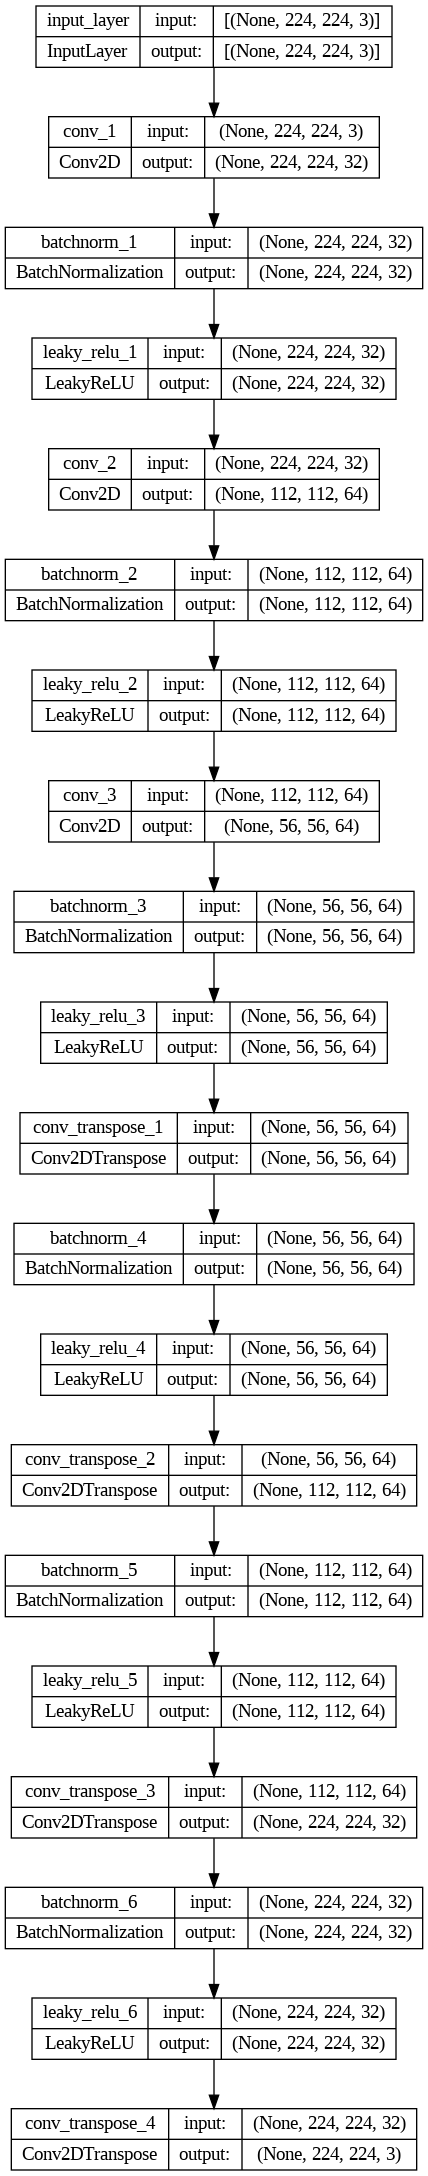

In [25]:
from keras.utils.vis_utils import plot_model

plot_model(custom_autoencoder_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

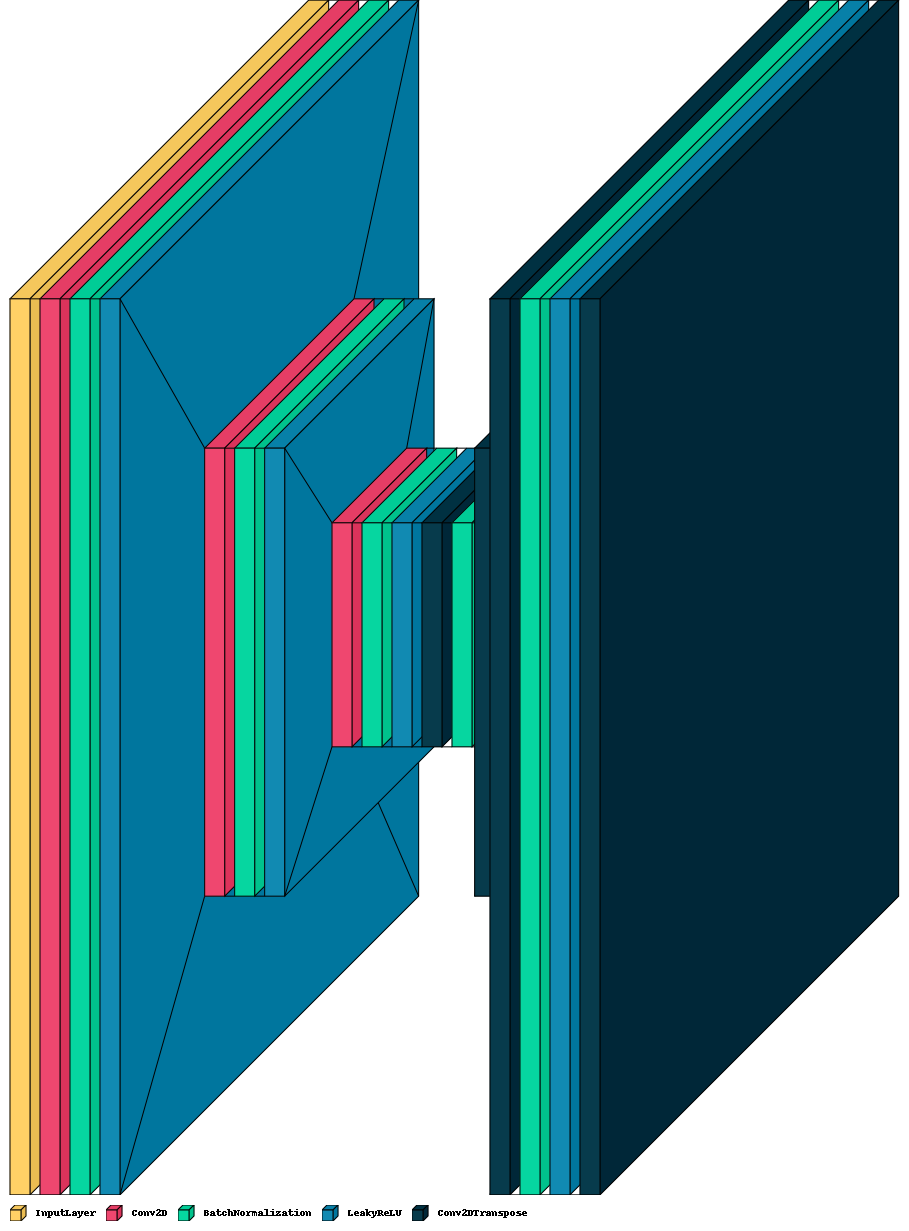

In [26]:
import visualkeras

visualkeras.layered_view(custom_autoencoder_model)
visualkeras.layered_view(custom_autoencoder_model, legend=True,
                         # draw_volume=False,
                         # spacing=30
                         )

### Build VGG-16 based Autoencoder

In [27]:
from tensorflow.keras.applications import VGG16

VGG16_INPUT_SHAPE = (224, 224, 3)

def get_vgg16_encoder():
    vgg = VGG16(weights='imagenet', include_top=False, input_shape=VGG16_INPUT_SHAPE)
    vgg.trainable = False
    return vgg

In [28]:
vgg16_encoder_model = get_vgg16_encoder()
vgg16_encoder_model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

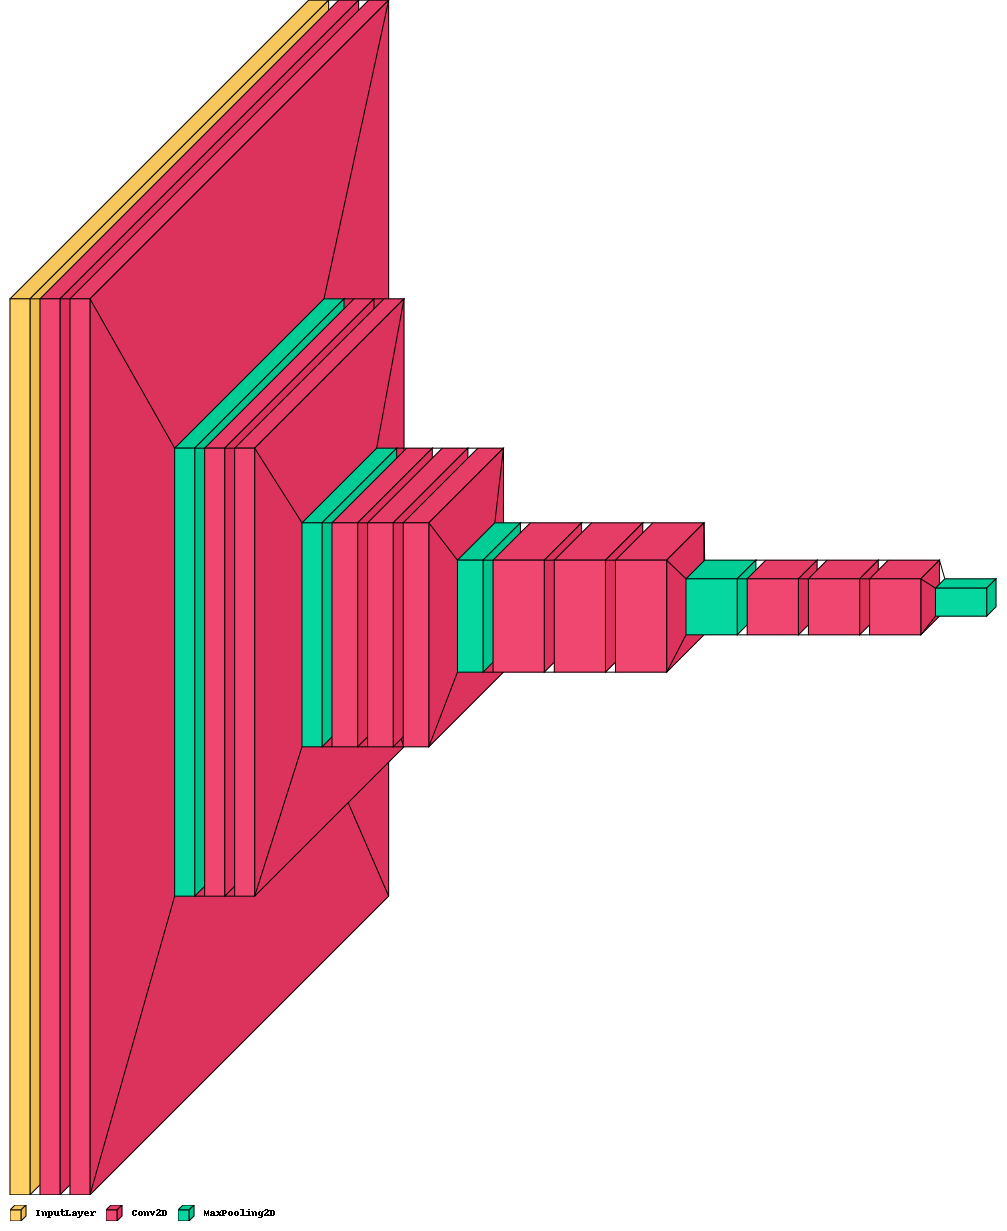

In [29]:
visualkeras.layered_view(vgg16_encoder_model)
visualkeras.layered_view(vgg16_encoder_model, legend=True,
                         # draw_volume=False,
                         # spacing=30
                         )

In [30]:
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D
from tensorflow.keras.models import Model

def get_vgg16_decoder():
    input_layer = Input(shape=(7, 7, 512))  # Output shape from the VGG-16 encoder

    # Decoder layers
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(input_layer)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='sigmoid', padding='same')(x)  # Output shape matches input image shape
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='sigmoid', padding='same')(x)  # Output shape matches input image shape
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Output shape matches input image shape

    return Model(inputs=input_layer, outputs=x)

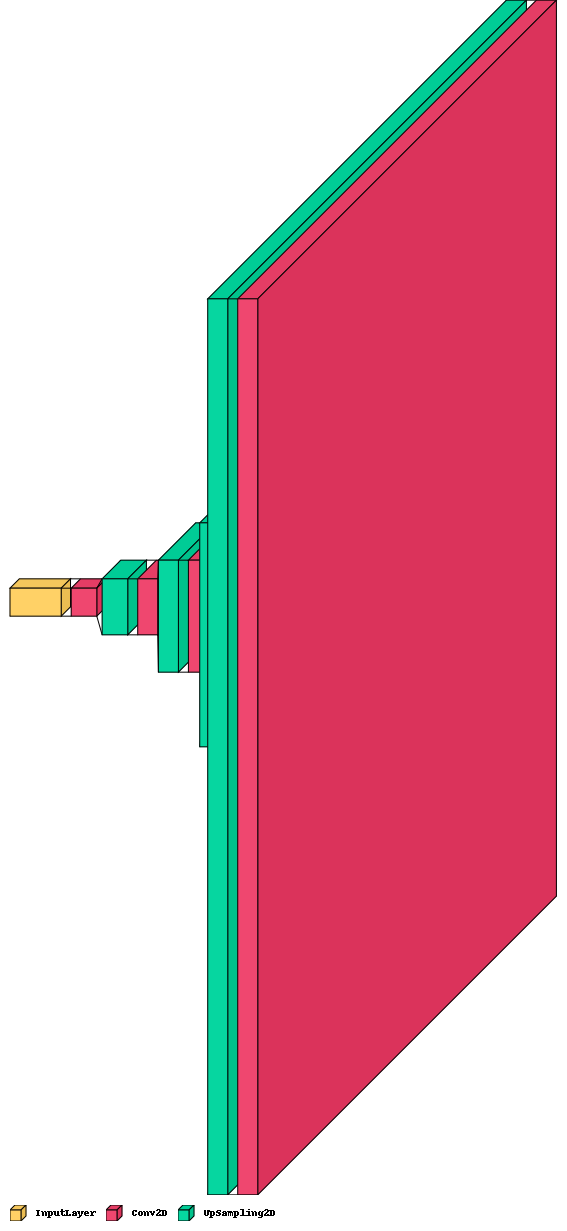

In [31]:
vgg16_decoder_model = get_vgg16_decoder()
visualkeras.layered_view(vgg16_decoder_model)
visualkeras.layered_view(vgg16_decoder_model, legend=True,
                         # draw_volume=False,
                         # spacing=30
                         )

In [32]:
vgg16_decoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7, 7, 512)]       0         
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 256)         1179904   
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       295040    
                                                                 
 up_sampling2d_1 (UpSampling  (None, 28, 28, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        7379

In [33]:
bottleneck_shape = vgg16_encoder_model.output_shape[1:]  # Get the output shape of the encoder
bottleneck_shape

(7, 7, 512)

In [34]:
def get_vgg16_autoencoder():
    encoder = get_vgg16_encoder()
    decoder = get_vgg16_decoder()

    input_layer = Input(shape=VGG16_INPUT_SHAPE)  # Input shape of the data

    # Connect encoder and decoder
    encoded = encoder(input_layer)
    decoded = decoder(encoded)

    # Create the autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=decoded)

    return autoencoder

In [35]:
'''
def get_VGG16_autoencoder_basic():
    input_layer = Input(shape=VGG16_INPUT_SHAPE)  # Input shape of the data

    encoder = get_vgg16_encoder()

    # Encoder Layers
    # vgg = VGG16(weights='imagenet', include_top=False, input_shape=VGG16_INPUT_SHAPE)
    # vgg.trainable = False

    encoded = encoder(input_layer)

    # Decoder Layers
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='sigmoid', padding='same')(x)  # Output shape matches input image shape
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='sigmoid', padding='same')(x)  # Output shape matches input image shape
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Output shape matches input image shape

    return Model(inputs=input_layer, outputs=x)

vgg16_autoencoder_model = get_VGG16_autoencoder_basic()

vgg16_autoencoder_model.summary()
'''

"\ndef get_VGG16_autoencoder_basic():\n    input_layer = Input(shape=VGG16_INPUT_SHAPE)  # Input shape of the data\n\n    encoder = get_vgg16_encoder()\n\n    # Encoder Layers\n    # vgg = VGG16(weights='imagenet', include_top=False, input_shape=VGG16_INPUT_SHAPE)\n    # vgg.trainable = False\n\n    encoded = encoder(input_layer)\n\n    # Decoder Layers\n    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)\n    x = UpSampling2D((2, 2))(x)\n    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)\n    x = UpSampling2D((2, 2))(x)\n    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)\n    x = UpSampling2D((2, 2))(x)\n    x = Conv2D(32, (3, 3), activation='sigmoid', padding='same')(x)  # Output shape matches input image shape\n    x = UpSampling2D((2, 2))(x)\n    x = Conv2D(32, (3, 3), activation='sigmoid', padding='same')(x)  # Output shape matches input image shape\n    x = UpSampling2D((2, 2))(x)\n    x = Conv2D(3, (3, 3), activati

In [36]:
vgg16_autoencoder_model = get_vgg16_autoencoder()

vgg16_autoencoder_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 model_2 (Functional)        (None, 224, 224, 3)       1577315   
                                                                 
Total params: 16,292,003
Trainable params: 1,577,315
Non-trainable params: 14,714,688
_________________________________________________________________


### SSIM Loss

SSIM measures Structural Similarity between two images in terms of luminance, contrast, and structure. A value of 1 for SSIM indicates identical images. You want the SSIM loss function to be a minimum when training the autoencoder on good images.

![](https://vicuesoft.com/glossary/ssim-ms-ssim.png)

The SSIM index is a development of traditional methods such as PSNR (peak signal-to-noise ratio) and the MSE method, which turned out to be incompatible with the physiology of human perception. The difference with other techniques such as MSE or PSNR is that these approaches estimate absolute errors. Structural information is the idea that the pixels have strong inter-dependencies especially when they are spatially close. These dependencies carry important information about the structure of the objects in the visual scene.

The SSIM index is calculated on various windows of an image. The above formula is applicable only for the brightness of the image, which is used to assess the quality. The resulting SSIM index ranges from -1 to +1. A value of +1 is achieved only with the complete authenticity of the samples. Typically, the metric is calculated for an 8 x 8 pixel window. The window can be displaced by a pixel, but experts recommend using groups of windows to reduce the complexity of the calculations.

A more advanced form of SSIM, called **Multiscale SSIM (MS-SSIM)**, is performed at multiple scales through a multi-step downsampling process, reminiscent of multiscale processing in the early visual system. It has been shown to perform equally well or better than SSIM with various databases of subjective images and videos.

In [37]:
def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

### Compile the Model

In [38]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005)
custom_autoencoder_model.compile(optimizer=optimizer, loss=SSIMLoss)

### Compile VGG16 AutoEncoder Model

In [39]:
vgg16_autoencoder_model = get_vgg16_autoencoder()

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

# vgg16_autoencoder_model.compile(optimizer='adam', loss='mean_squared_error')
vgg16_autoencoder_model.compile(optimizer='adam', loss=SSIMLoss)

In [40]:
EPOCHS = 50
BATCH_SIZE = 32

In [41]:
custom_autoencoder_model_hist = custom_autoencoder_model.fit(
                x_train_transistor, x_train_transistor,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                shuffle=True,
                validation_data=(x_test_transistor, x_test_transistor)
                )

Epoch 1/50
7/7 [==============================] - 27s 638ms/step - loss: 0.8679 - val_loss: 0.5818
Epoch 2/50
7/7 [==============================] - 2s 235ms/step - loss: 0.5863 - val_loss: 0.5785
Epoch 3/50
7/7 [==============================] - 2s 238ms/step - loss: 0.3996 - val_loss: 0.5749
Epoch 4/50
7/7 [==============================] - 2s 226ms/step - loss: 0.3084 - val_loss: 0.5697
Epoch 5/50
7/7 [==============================] - 1s 214ms/step - loss: 0.2574 - val_loss: 0.5636
Epoch 6/50
7/7 [==============================] - 2s 235ms/step - loss: 0.2172 - val_loss: 0.5556
Epoch 7/50
7/7 [==============================] - 2s 237ms/step - loss: 0.1851 - val_loss: 0.5478
Epoch 8/50
7/7 [==============================] - 1s 213ms/step - loss: 0.1586 - val_loss: 0.5381
Epoch 9/50
7/7 [==============================] - 2s 237ms/step - loss: 0.1377 - val_loss: 0.5301
Epoch 10/50
7/7 [==============================] - 1s 211ms/step - loss: 0.1213 - val_loss: 0.5225
Epoch 11/50
7/7 [=

In [42]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history, plt_type='loss'):
  """
  Returns separate loss curves for training and validation metrics.

  Parameters
  history: Model training history
  plt_type: 'accuracy', 'loss', 'both'
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  if ('accuracy' in plt_type) or ('both' in plt_type):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  if ('accuracy' in plt_type) or ('both' in plt_type):
    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

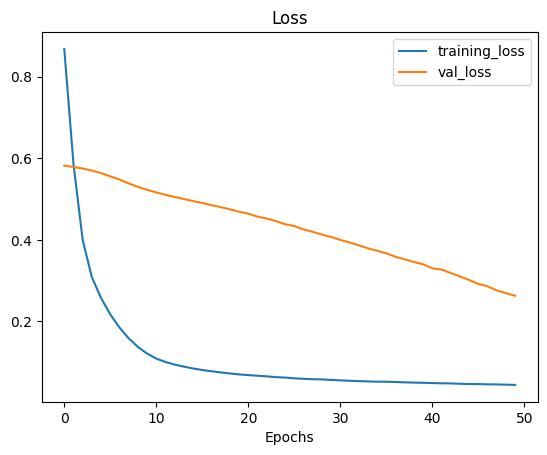

In [43]:
# Plot model loss curves
plot_loss_curves(custom_autoencoder_model_hist)

In [44]:
type(transistor_train_data)

tensorflow.python.data.ops.batch_op._BatchDataset

### Save the custom Model

If you are using the SavedModel format, you can skip this section. The key difference between high-level .keras/HDF5 formats and the low-level SavedModel format is that the .keras/HDF5 formats uses object configs to save the model architecture, while SavedModel saves the execution graph. Thus, SavedModels are able to save custom objects like subclassed models and custom layers without requiring the original code. However, debugging low-level SavedModels can be more difficult as a result, and we recommend using the high-level .keras format instead due to its name-based, Keras-native nature.

https://www.tensorflow.org/tutorials/keras/save_and_load

In [45]:
# custom_autoencoder_model.save('custom_auto_encoder_model_mvtec_transistor_ds_07_29_2023_11_10.keras')

In [46]:
# loaded_custom_autoencoder_model = tf.keras.models.load_model('custom_auto_encoder_model_mvtec_transistor_ds_07_29_2023_11_10')

# loaded_custom_autoencoder_model.summary()

# ! These lines above gives ValueError: Unknown loss function: 'SSIMLoss'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [47]:
vgg16_autoencoder_model_hist = vgg16_autoencoder_model.fit(
            x_train_transistor,
            x_train_transistor,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            shuffle=True,
            validation_data=(x_test_transistor, x_test_transistor)
            )

Epoch 1/50
7/7 [==============================] - 20s 2s/step - loss: 0.5331 - val_loss: 0.5182
Epoch 2/50
7/7 [==============================] - 2s 308ms/step - loss: 0.5019 - val_loss: 0.4690
Epoch 3/50
7/7 [==============================] - 2s 257ms/step - loss: 0.4517 - val_loss: 0.4258
Epoch 4/50
7/7 [==============================] - 2s 256ms/step - loss: 0.4156 - val_loss: 0.3935
Epoch 5/50
7/7 [==============================] - 2s 258ms/step - loss: 0.3915 - val_loss: 0.3779
Epoch 6/50
7/7 [==============================] - 2s 311ms/step - loss: 0.3723 - val_loss: 0.3585
Epoch 7/50
7/7 [==============================] - 2s 261ms/step - loss: 0.3535 - val_loss: 0.3405
Epoch 8/50
7/7 [==============================] - 2s 257ms/step - loss: 0.3386 - val_loss: 0.3228
Epoch 9/50
7/7 [==============================] - 2s 255ms/step - loss: 0.3221 - val_loss: 0.3289
Epoch 10/50
7/7 [==============================] - 2s 265ms/step - loss: 0.3123 - val_loss: 0.2993
Epoch 11/50
7/7 [====

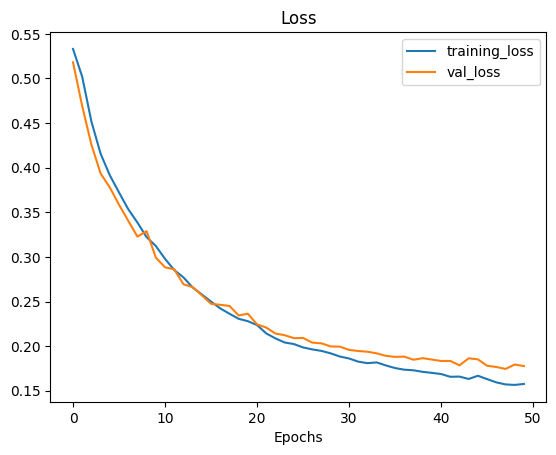

In [48]:
# Plot model loss curves
plot_loss_curves(vgg16_autoencoder_model_hist)

### Reconstruct the Fashion MNIST images for the test data and visualize

In [49]:
VIS_SAMPLE_COUNT = 10

In [50]:
decoded_imgs = custom_autoencoder_model.predict(x_test_transistor)

2/2 [==============================] - 0s 81ms/step


In [51]:
def plot_reconstructed_img(x_test, x_recons, plot_size):
    plt.figure(figsize=(20, 4))

    for i in range(1, plot_size + 1):
      # Display original
      ax = plt.subplot(2, plot_size, i)
      plt.imshow(x_test[i] \
      # .reshape(28, 28)
      )
      plt.gray()
      ax.get_xaxis().set_visible(False)
      plt.title("Original")
      ax.get_yaxis().set_visible(False)

      # Display reconstruction
      ax = plt.subplot(2, plot_size, i + plot_size)
      plt.title("Reconstructed")
      plt.imshow(decoded_imgs[i] \
      # .reshape(28, 28)
      )
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

    plt.show()

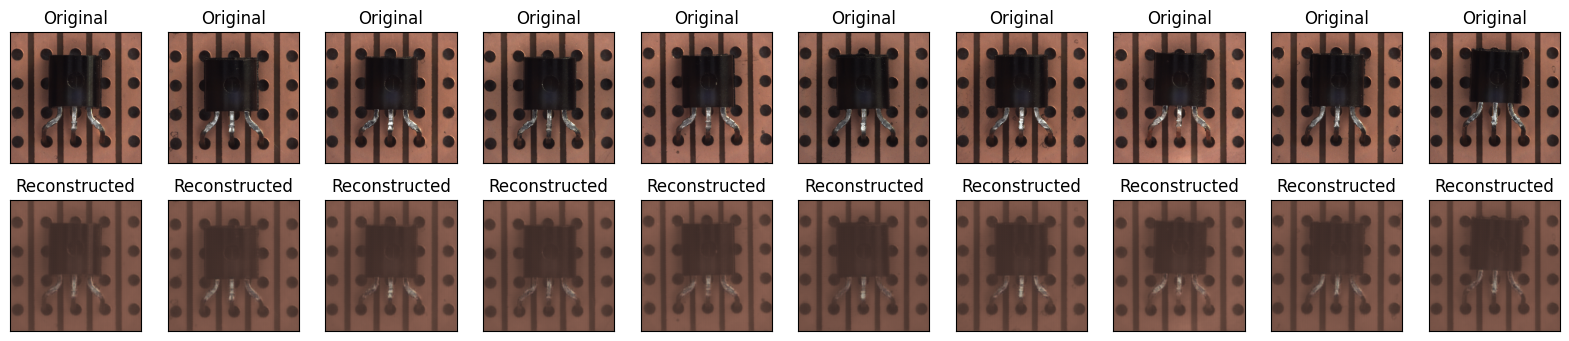

In [52]:
plot_reconstructed_img(x_test_transistor, decoded_imgs, VIS_SAMPLE_COUNT)

In [53]:
decoded_transistor_imgs = custom_autoencoder_model.predict(x_test_transistor)
decoded_transistor_misplaced= custom_autoencoder_model.predict(x_test_misplaced)
decoded_transistor_cutlead= custom_autoencoder_model.predict(x_test_cutlead)
decoded_transistor_damaged= custom_autoencoder_model.predict(x_test_damaged)

1/1 [==============================] - 0s 27ms/step


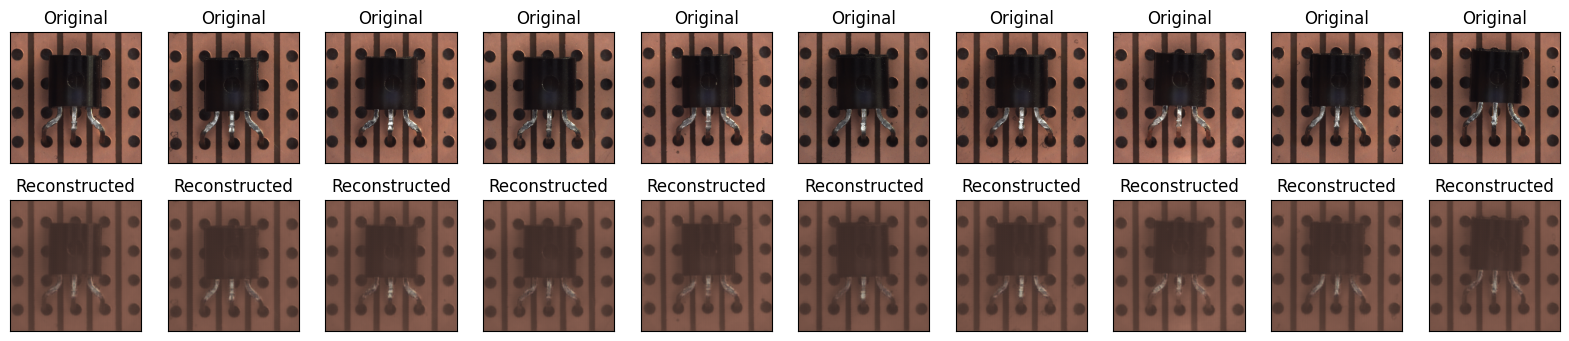

In [54]:
plot_reconstructed_img(x_test_transistor, decoded_transistor_imgs, VIS_SAMPLE_COUNT)

In [55]:
VIS_SAMPLE_COUNT = 5

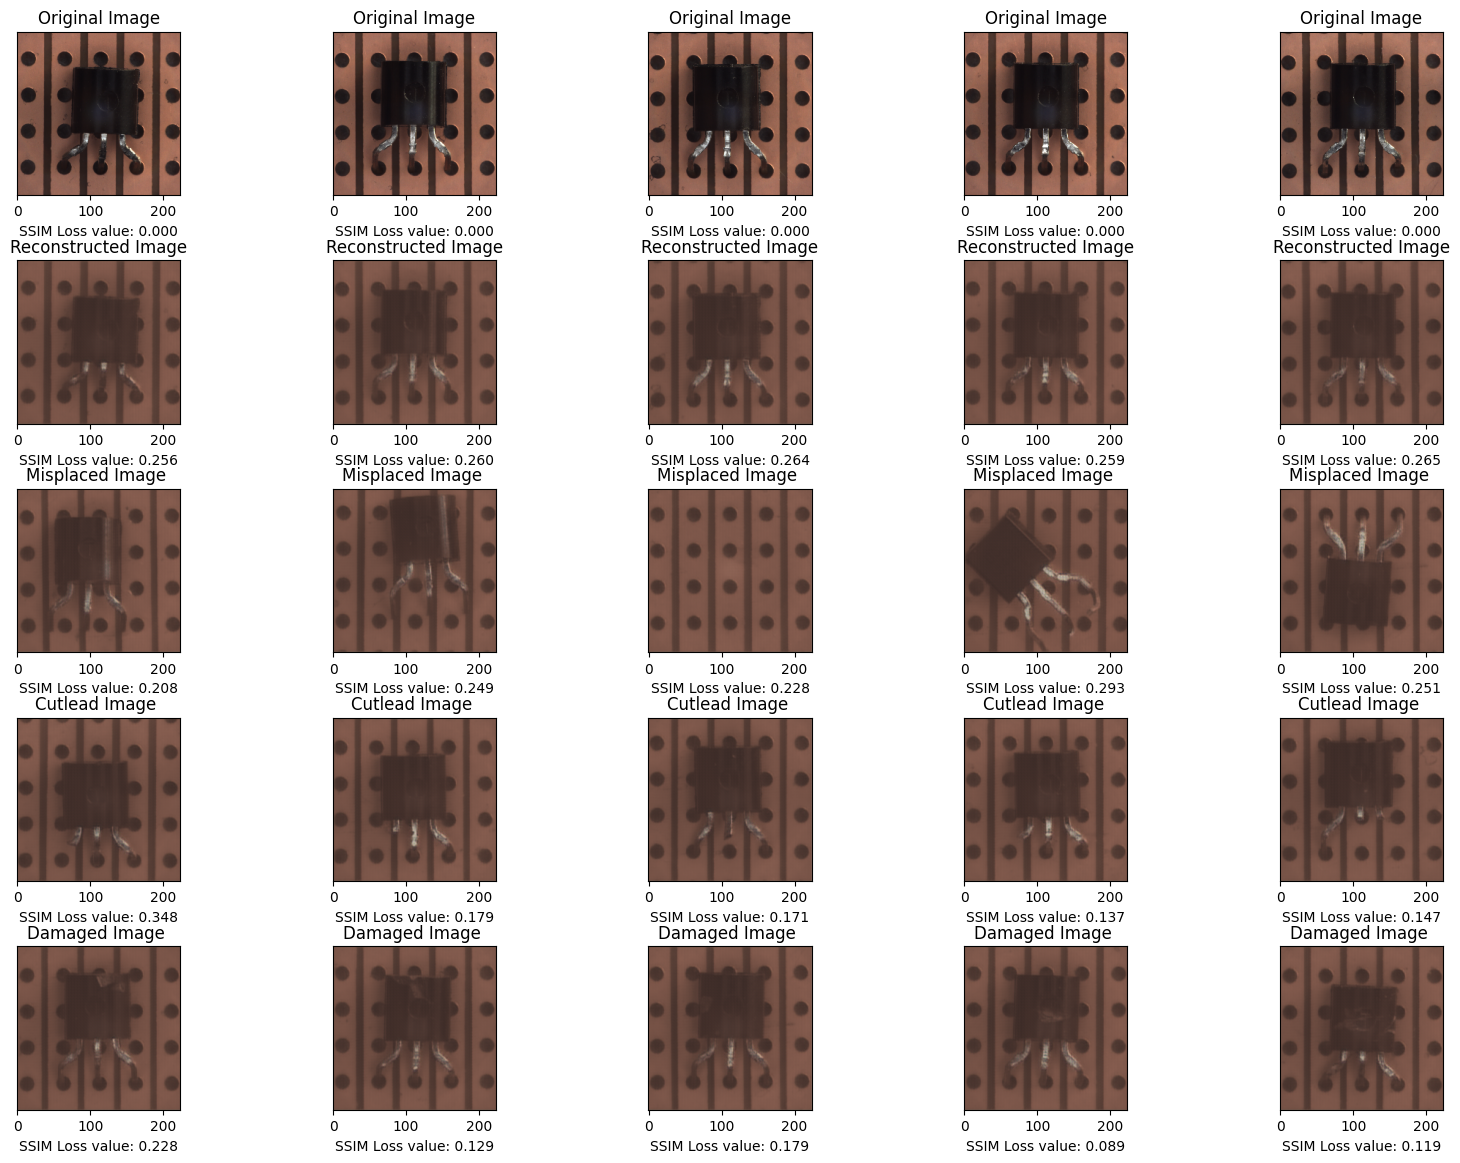

In [56]:
plt.figure(figsize=(20, 14), dpi=100)
plt.subplots_adjust(wspace=0.1, hspace=0.4)
plt_a=1

for i in range(VIS_SAMPLE_COUNT):
    # ======================= Original - Original =======================
    # Original testing transistor dataset vs testing transistor dataset (Identical)
    ax = plt.subplot(5, VIS_SAMPLE_COUNT, plt_a)
    plt.imshow(x_test_transistor[i] \
    # .reshape(224,224)
    )
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(x_test_transistor[i], x_test_transistor[i])  # Calculate SSIM
    ax.set_title("Original Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )

    # ======================= Good - Good =======================
    # Reconstructed good testing transistor data vs testing transistor dataset
    ax = plt.subplot(5, VIS_SAMPLE_COUNT, plt_a + VIS_SAMPLE_COUNT )
    plt.imshow(decoded_transistor_imgs[i] \
    # .reshape(224,224)
    )
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(decoded_transistor_imgs[i], x_test_transistor[i])  # Calculate SSIM
    ax.set_title("Reconstructed Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )

    # ======================= Misplaced - Good =======================
    # Reconstructed misplaced testing transistor data vs testing transistor dataset
    ax = plt.subplot(5, VIS_SAMPLE_COUNT, plt_a + 2*VIS_SAMPLE_COUNT)
    plt.imshow(decoded_transistor_misplaced[i] \
    # .reshape(224,224)
    )
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value = SSIMLoss(decoded_transistor_misplaced[i], decoded_transistor_imgs[i])  # Calculate SSIM
    label = 'SSIM Loss value: {:.3f}'
    ax.set_title("Misplaced Image " )
    ax.set_xlabel(label.format(value) )

    # ======================= Cutlead - Good =======================
    # Reconstructed misplaced testing transistor data vs testing transistor dataset
    ax = plt.subplot(5, VIS_SAMPLE_COUNT, plt_a + 3*VIS_SAMPLE_COUNT)
    plt.imshow(decoded_transistor_cutlead[i] \
    # .reshape(224,224)
    )
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value = SSIMLoss(decoded_transistor_cutlead[i], decoded_transistor_imgs[i])  # Calculate SSIM
    label = 'SSIM Loss value: {:.3f}'
    ax.set_title("Cutlead Image " )
    ax.set_xlabel(label.format(value) )

    # ======================= Damaged - Good =======================
    # Reconstructed misplaced testing transistor data vs testing transistor dataset
    ax = plt.subplot(5, VIS_SAMPLE_COUNT, plt_a + 4*VIS_SAMPLE_COUNT)
    plt.imshow(decoded_transistor_damaged[i] \
    # .reshape(224,224)
    )
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value = SSIMLoss(decoded_transistor_damaged[i], decoded_transistor_imgs[i])  # Calculate SSIM
    label = 'SSIM Loss value: {:.3f}'
    ax.set_title("Damaged Image " )
    ax.set_xlabel(label.format(value) )

    plt_a+=1
plt.show()

In [57]:
x_test_transistor.shape

(60, 224, 224, 3)

In [58]:
x_test_transistor[0].shape

(224, 224, 3)

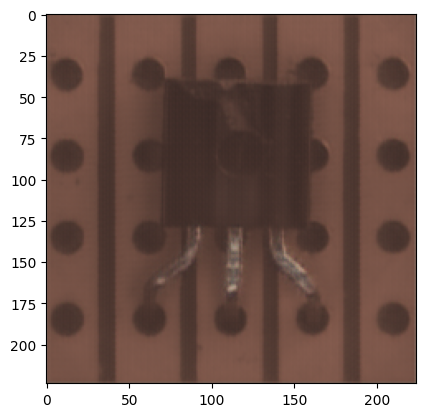

In [59]:
plt.imshow(decoded_transistor_damaged[1])

In [60]:
decoded_transistor_damaged[1].shape

(224, 224, 3)

In [61]:
decoded_transistor_damaged_gray = tf.image.rgb_to_grayscale(decoded_transistor_damaged[1])

In [62]:
decoded_transistor_damaged_gray.shape

TensorShape([224, 224, 1])

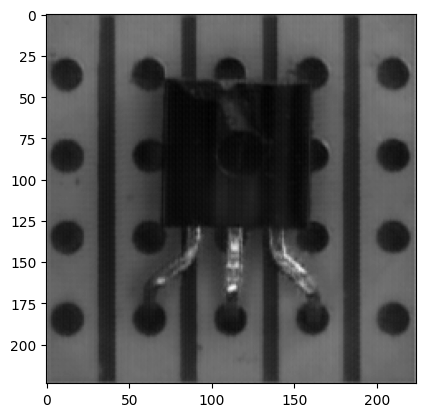

In [63]:
plt.imshow(decoded_transistor_damaged_gray)

In [64]:
tf.math.reduce_max(decoded_transistor_damaged_gray)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6414684>

In [65]:
decoded_transistor_damaged_gray_np = decoded_transistor_damaged_gray.numpy()

In [66]:
decoded_transistor_damaged_gray_np[0].flatten().shape

(224,)

(array([8.8160e+03, 1.0907e+04, 5.1410e+03, 1.2221e+04, 1.2493e+04,
        4.8400e+02, 4.9000e+01, 3.6000e+01, 2.3000e+01, 6.0000e+00]),
 array([0.18277401, 0.22864345, 0.27451289, 0.32038233, 0.36625177,
        0.41212121, 0.45799065, 0.50386012, 0.54972953, 0.59559894,
        0.64146841]),
 <BarContainer object of 10 artists>)

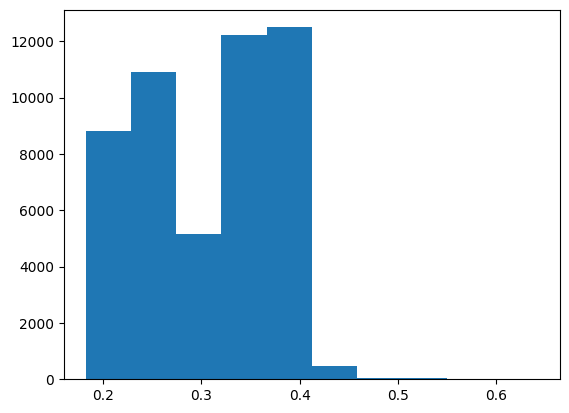

In [67]:
plt.hist(decoded_transistor_damaged_gray_np.ravel())

------ x1, y1 ---------- x2, y1

--------------------------------------.

--------------------------------------.

--------------------------------------.

--------------------------------------.

------ x1, y2 ---------- x2, y2


In [68]:
def get_detection_coordinates(gray_scl_img):
  detection_co_x = []
  detection_co_y = []

  y1 = 0
  x1 = 0

  for y_axis in range(gray_scl_img.shape[1]):
    for x_axis in range(gray_scl_img.shape[0]):
      if (gray_scl_img[y_axis][x_axis] > 0.5) and (x1 == 0):
        x1 = x_axis
        y1 = y_axis
        detection_co_x.append(x1)
        detection_co_y.append(y1)
        break

    x1=0

  for y_axis in range(gray_scl_img.shape[1]):
    for x_axis in range(gray_scl_img.shape[0]):
      if (gray_scl_img[(gray_scl_img.shape[1] -1 - y_axis)][(gray_scl_img.shape[0] -1 - x_axis)] > 0.5) and (x1 == 0):
        x1 = (gray_scl_img.shape[0]-1 - x_axis)
        y1 = (gray_scl_img.shape[1]-1 - y_axis)
        detection_co_x.append(x1)
        detection_co_y.append(y1)
        break

    x1=0

  x1 = min(detection_co_x)
  x2 = max(detection_co_x)
  y1 = min(detection_co_y)
  y2 = max(detection_co_y)

  return x1, y1, x2, y2


In [69]:
(x1, y1, x2, y2) = get_detection_coordinates(decoded_transistor_damaged_gray_np)

In [70]:
import cv2
from google.colab.patches import cv2_imshow

def draw_detection_bounding_box(img_src, x1, y1, x2, y2, size=(224, 224)):
    image = cv2.imread(img_src)
    image = cv2.resize(image, (224, 224))

    # Define the coordinates of the top-left and bottom-right corners of the rectangle
    top_left = (x1, y1)  # (x, y) coordinates of the top-left corner
    bottom_right = (x2, y2)  # (x, y) coordinates of the bottom-right corner

    # Define the color and thickness of the rectangle (in BGR format)
    color = (0, 0, 255)  # Green color
    thickness = 2

    # Draw the rectangle on the image
    cv2.rectangle(image, top_left, bottom_right, color, thickness)

    # Display the image with the rectangle
    cv2_imshow(image)

    # Wait for a key press and then close the window
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [75]:
# draw_detection_bounding_box('/content/transistor/test/damaged_case/001.png', x1, y1, x2, y2)

# decoded_transistor_cutlead_gray_np = (tf.image.rgb_to_grayscale(decoded_transistor_cutlead[2])).numpy()

# (x1, y1, x2, y2) = get_detection_coordinates(decoded_transistor_cutlead_gray_np)

# draw_detection_bounding_box('/content/transistor/test/cut_lead/003.png', x1, y1, x2, y2)

# decoded_transistor_misplaced_gray_np = (tf.image.rgb_to_grayscale(decoded_transistor_misplaced[0])).numpy()

# (x1, y1, x2, y2) = get_detection_coordinates(decoded_transistor_misplaced_gray_np)

# draw_detection_bounding_box('/content/transistor/test/misplaced/008.png', x1, y1, x2, y2)

1/1 [==============================] - 0s 26ms/step


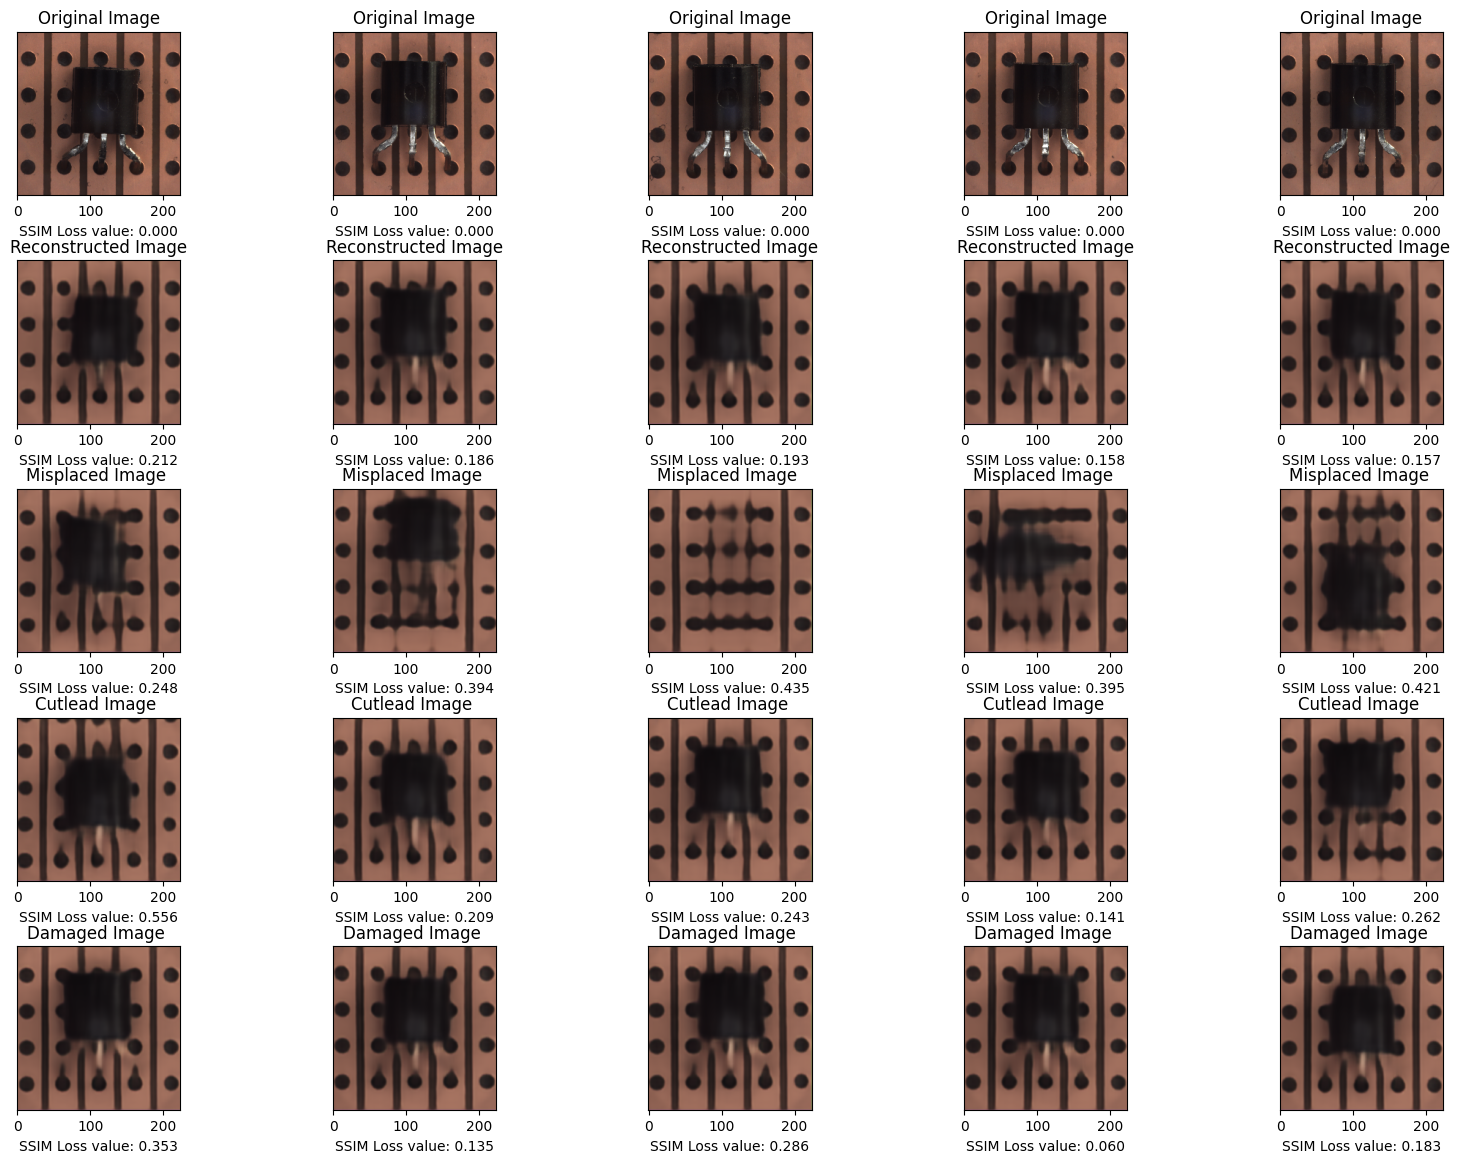

In [74]:
'''x_test_misplaced
x_test_cutlead
x_test_damaged '''

decoded_transistor_imgs = vgg16_autoencoder_model.predict(x_test_transistor)
decoded_transistor_misplaced= vgg16_autoencoder_model.predict(x_test_misplaced)
decoded_transistor_cutlead= vgg16_autoencoder_model.predict(x_test_cutlead)
decoded_transistor_damaged= vgg16_autoencoder_model.predict(x_test_damaged)

plt.figure(figsize=(20, 14), dpi=100)
plt.subplots_adjust(wspace=0.1, hspace=0.4)
plt_a=1

for i in range(VIS_SAMPLE_COUNT):
    # ======================= Original - Original =======================
    # Original testing transistor dataset vs testing transistor dataset (Identical)
    ax = plt.subplot(5, VIS_SAMPLE_COUNT, plt_a)
    plt.imshow(x_test_transistor[i] \
    # .reshape(224,224)
    )
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(x_test_transistor[i], x_test_transistor[i])  # Calculate SSIM
    ax.set_title("Original Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )

    # ======================= Good - Good =======================
    # Reconstructed good testing transistor data vs testing transistor dataset
    ax = plt.subplot(5, VIS_SAMPLE_COUNT, plt_a + VIS_SAMPLE_COUNT )
    plt.imshow(decoded_transistor_imgs[i] \
    # .reshape(224,224)
    )
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(decoded_transistor_imgs[i], x_test_transistor[i])  # Calculate SSIM
    ax.set_title("Reconstructed Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )

    # ======================= Misplaced - Good =======================
    # Reconstructed misplaced testing transistor data vs testing transistor dataset
    ax = plt.subplot(5, VIS_SAMPLE_COUNT, plt_a + 2*VIS_SAMPLE_COUNT)
    plt.imshow(decoded_transistor_misplaced[i] \
    # .reshape(224,224)
    )
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value = SSIMLoss(decoded_transistor_misplaced[i], decoded_transistor_imgs[i])  # Calculate SSIM
    label = 'SSIM Loss value: {:.3f}'
    ax.set_title("Misplaced Image " )
    ax.set_xlabel(label.format(value) )

    # ======================= Cutlead - Good =======================
    # Reconstructed misplaced testing transistor data vs testing transistor dataset
    ax = plt.subplot(5, VIS_SAMPLE_COUNT, plt_a + 3*VIS_SAMPLE_COUNT)
    plt.imshow(decoded_transistor_cutlead[i] \
    # .reshape(224,224)
    )
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value = SSIMLoss(decoded_transistor_cutlead[i], decoded_transistor_imgs[i])  # Calculate SSIM
    label = 'SSIM Loss value: {:.3f}'
    ax.set_title("Cutlead Image " )
    ax.set_xlabel(label.format(value) )

    # ======================= Damaged - Good =======================
    # Reconstructed misplaced testing transistor data vs testing transistor dataset
    ax = plt.subplot(5, VIS_SAMPLE_COUNT, plt_a + 4*VIS_SAMPLE_COUNT)
    plt.imshow(decoded_transistor_damaged[i] \
    # .reshape(224,224)
    )
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value = SSIMLoss(decoded_transistor_damaged[i], decoded_transistor_imgs[i])  # Calculate SSIM
    label = 'SSIM Loss value: {:.3f}'
    ax.set_title("Damaged Image " )
    ax.set_xlabel(label.format(value) )

    plt_a+=1
plt.show()

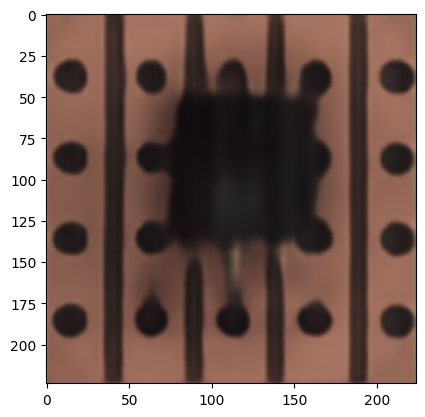

In [83]:
plt.imshow(decoded_transistor_imgs[0])

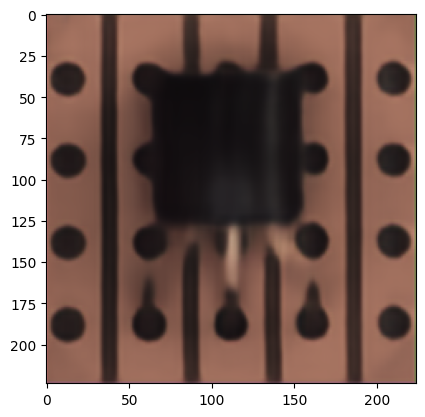

In [84]:
plt.imshow(decoded_transistor_damaged[0])

In [81]:
mse_array = tf.keras.metrics.mean_squared_error(
    decoded_transistor_imgs[0], decoded_transistor_damaged[0]
)

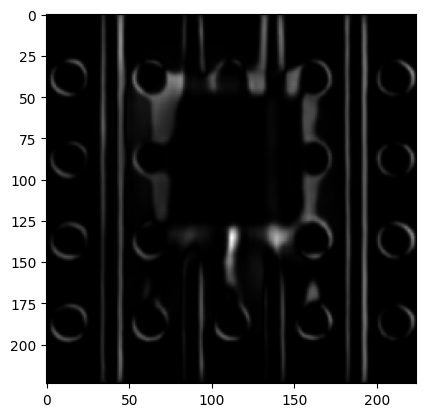

In [82]:
plt.imshow(mse_array)

### Reference

https://medium.com/analytics-vidhya/image-anomaly-detection-using-autoencoders-ae937c7fd2d1

https://lilianweng.github.io/posts/2018-08-12-vae/